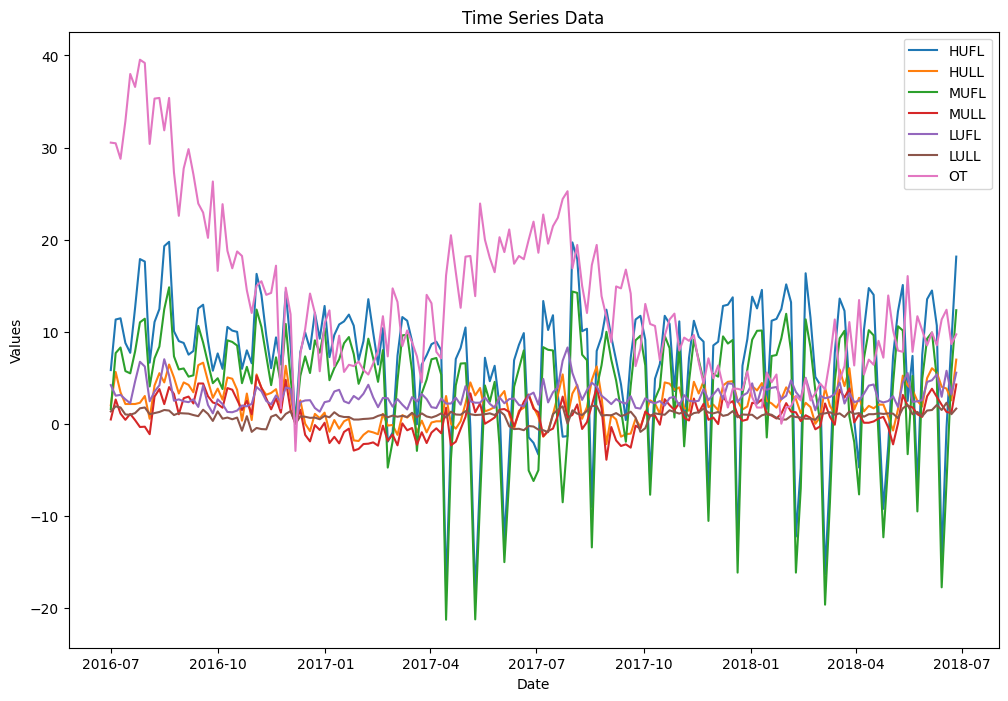

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = 'dataset/ETT-small/ETTh1.csv'
data = pd.read_csv(file_path)

# Convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Sample one data point every 100
sampled_data = data.iloc[::100, :]

# Plot the data
plt.figure(figsize=(12, 8))

# Plot each column against the date
plt.plot(sampled_data['date'], sampled_data['HUFL'], label='HUFL')
plt.plot(sampled_data['date'], sampled_data['HULL'], label='HULL')
plt.plot(sampled_data['date'], sampled_data['MUFL'], label='MUFL')
plt.plot(sampled_data['date'], sampled_data['MULL'], label='MULL')
plt.plot(sampled_data['date'], sampled_data['LUFL'], label='LUFL')
plt.plot(sampled_data['date'], sampled_data['LULL'], label='LULL')
plt.plot(sampled_data['date'], sampled_data['OT'], label='OT')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Data')
plt.legend()

# Show the plot
plt.show()
